# Clasificación de textos

El siguiente código de clasificación de textos con Redes Neuronales Recurrentes está basado en https://www.tensorflow.org/text/tutorials/text_classification_rnn.

Las modificaciones que se hacen son las siguientes:


1.   Modificación del texto para adaptación a la audiencia en español.
2.   Adaptación del código a las versiones actuales de Tensorflow.
3.   Inclusión de redes neuronales recurrentes básicas y GRU, además de métodos clásicos.
4.   La barra de progreso se va a mostrar.
5.   Algunas indicaciones explicativas se añadieron.
6.   Se hizo otro *shuffle* de los datos.
7.   Ligeros cambios en algunas constantes.
8.   No validaremos con el conjunto de prueba.

Dicho esto, no me demanden. Aquí muestro la licencia:



In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Introducción

En el siguiente código vamos a ver cómo clasificar textos con diversas redes neuronales recurrentes. Para ello utilizaremos el *dataset* IMDB, que incluye reseñas de películas, etiquetadas como "positiva" o "negativa". Esto es un ejemplo de **análisis de sentimientos**.

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

La siguiente función nos permite graficar con facilidad lo que necesitamos, que es la evolución de las métricas a través de las épocas.  

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric])

## Descargar y configurar el *dataset*


Necesitamos descargar el dataset IMDB utilizando el formato de Tensorflow para conjuntos de datos [TFDS](https://www.tensorflow.org/datasets). Para más detalles de cómo cargar y ordenar manualmente el conjunto de datos, véase el siguiente [tutorial](https://www.tensorflow.org/tutorials/load_data/text).

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.WN3LQU_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.WN3LQU_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.WN3LQU_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Los *datasets* de Tensorflow suelen ser más difíciles de manejar que los de Keras nativos. Por ejemplo, no podemos llamar a los datos simplemente haciendo

```
train_dataset[0]
```

Para acceder y ver un dato, tenemos que utilizar ```dataset.take(n)``` donde n es el número de datos que queremos ver. No podemos acceder al mismo directamente, sino que tenemos que convertirlo a una lista.


In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
  <tf.Tensor: shape=(), dtype=int64, numpy=0>)]

En general también podemos convertir todo el *dataset* a una enorme lista.

In [ ]:
list(train_dataset)[0][0].numpy()

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Podemos ver varios ejemplos utilizando un bucle for.

In [ ]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

El *dataset* es muy grande, como podemos ver a continuación y está ordenado, lo cual no es necesariamente bueno en algunos casos. Este conjunto de datos es tan grande que incluso algunos transformadores como DistilBERT no pueden digerirlos si tenemos recursos limitados.

In [ ]:
len(train_dataset)

25000

In [ ]:
len(test_dataset)

25000

Los datos están ordenados en el sentido que tenemos

texto0 $→$ 0

texto1 $→$ 0

texto2 $→$ 0

$\vdots$

texto12500 $→$ 1

texto12501 $→$ 1

Tenemos que desordenarlos si queremos tomar una muestra (¿por qué?). Ese proceso de desordenar se conoce como *shuffle* y en Tensorflow necesitamos especificar el tamaño del *buffer*, es decir, el espacio de la memoria que vamos a destinar para ese desordenamiento. Entre más grande el *buffer* es mejor la calidad de la aleatoriedad de los datos mezclados pero ocupamos más recursos. La regla básica es: si tu RAM explota porque es pequeña, utiliza un tamaño de *buffer* menor.



In [ ]:
BUFFER_SIZE = 10000

small_train_dataset = train_dataset.shuffle(BUFFER_SIZE).take(2000)
small_test_dataset =  test_dataset.shuffle(BUFFER_SIZE).take(400)

In [ ]:
for example, label in small_train_dataset.take(5):
  print('texts: ', example.numpy())
  print('labels: ', label.numpy())
  print()

texts:  b"This Showtime movie really deserves a far better viewer rating than a 4.5; I gave it a 10 based on the story and the acting of the two stars. After reading the viewer comments, I was surprised at how many folks expected this movie to be a comedy. Yeah, I see that IMDb lists it as Comedy/Drama under Genre. That sure is misleading, isn't it? Fortunately, I saw the movie before logging onto this website so I did not have that expectation. In fact, based on the synopsis of what I heard, I fully expected it to simply be a Drama. I'm wondering if disappoint at this not being a funny movie caused so many low votes.<br /><br />Another factor that might have caused low votes is that this movie is very much 'character-driven'. 'Driving Miss Daisy' is an example of another character-driven movie that comes to mind. Someone's previous comment complained about a boring trial. Tom's (Danny Glover) work scenes seemed to distract from the real plot of the movie. That is, how he was engineeri

El proceso de *shuffle* también se puede organizar directamente en *batches*, que es la forma que Tensorflow prefiere para organizar sus conjuntos de datos. Para ello definimos un tamaño de lote.

In [ ]:
BATCH_SIZE = 64

``prefetch(tf.data.AUTOTUNE)`` permite que se preprocesen los datos en segundo plano mientras el modelo se entrena y ``tf.data.AUTOTUNE`` permite que se ajuste el número de elementos a preprocesar considerando los recursos, lo cual optimiza el rendimiento.

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Ahora ``train_dataset.take(1)`` tiene un lote, por lo que es normal esperar que tenga 64 elementos.

In [ ]:
list(train_dataset.take(1))[0][0].numpy()

array([b'The extraordinary Rosemary Forsyth is the main reason to see this flick. Why she never became a bigger store may never be known. But she is exceptional and steals every scene she\'s in. Garson Kanin directed this piece of fluff and the cast is first rate, with Robert Drivas and Brenda Vaccaro especially memorable. A "9" out of "10."',
       b'As a huge baseball fan, my scrutiny of this film is how realistic it appears. Dennis Quaid had all of the right moves and stances of a major league pitcher. It is a fantastic true story told with just a little too much "Disney" for my taste.',
       b'I liked the movie a real lot. Wanted to see it just for Dara Tomanovich, but the plot and story were ok too. A very cool change in plot when you least expect it.',
       b'My choice for greatest movie ever used to be Laughton\'s "Night of the Hunter" which remains superb in my canon. But, it may have been supplanted by "Shower" which is the most artistically Daoist movie I have seen. The 

In [ ]:
list(train_dataset.take(1))[0][0].numpy()[0]

b"If you haven't seen this obscure little charmer, you should seek it out. It is the story of a bumbling, wartime Sad Sack (Fred MacMurray) who is listed 4-F each time he attempts to join any branch of the military. He finds a magic lamp which of course contains a genie (Gene Sheldon), but the genie is even more bumbling than MacMurray is, sending him across time to serve in all the wrong times and places than the one he wants. It is cute, cheerful, and pure fluff, and you can't help but like it. The plots is much like a Disney film, particularly since the two stars (MacMurray and Sheldon) both made numerous Disney films in the 50's and 60's, although not together. Needless to say, it all ends well for everyone, and the viewer goes away feeling pretty good."

In [ ]:
list(train_dataset.take(1))[0][1]

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1])>

In [ ]:
list(train_dataset.take(1))[0][0].numpy().shape

(64,)

Notemos que el tamaño del *dataset* no se alteró.

In [ ]:
len(train_dataset)

391

In [ ]:
len(train_dataset)*64

25024

El último lote tendrá menos de 64 datos.



In [ ]:
list(train_dataset)[-1][0].numpy().shape

(40,)

In [ ]:
(len(train_dataset) -1 )*64 + 40

25000

Veamos algunos datos.

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I haven\'t watched the movie yet, but can\'t wait to see it! It seems very interesting and inspirational. It was one of the most interesting trailers I\'ve ever seen: the questions it posed really stopped me and made me think, the unique approach to the sport of boxing as a metaphor for the "battle within"... thank god somebody is hitting another angle with the boxing thing. This film looks so fresh and smart. And the actor is really hot. I especially enjoyed the short clip with the actor from the Rocky movies, really clever. I thought that the topic selected-overcoming adversities and childhood traumas-is timeless, and god knows a lot of people need it. Bring it on.'
 b'The one of the most remarkable sci-fi movies of the millennium. Not only a movie but an incredible future vision, this movie establishes a new standard of s/f movies. hail and kill!'
 b"Just a dumb old movie. First Stanwyck's son gets his foot trapped in a really dumb way, and then her husband gets his foot 

# Clasificación con métodos clásicos

Para utilizar los clasificadores clásicos, es muy difícil utilizar todo el conjunto de datos por lo que tenemos que utilizar la versión reducida (``small_train_dataset`` y ``small_test_dataset``). Eso normalmente es un problema, porque no estamos midiendo de la misma forma, pero al menos somos conscientes de que estamos tomando una muestra de los datos para tal fin. No obstante, nuestros datos también están en un formato de Tensorflow, por lo que tenemos que convertirlos a una lista de textos.

In [ ]:
dato1 = list(small_train_dataset)[0]

In [ ]:
dato1

(<tf.Tensor: shape=(), dtype=string, numpy=b'Brilliant execution in displaying once and for all, this time in the venue of politics, of how "good intentions do actually pave the road to hell". Excellent!'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [ ]:
dato1[0].numpy()

b'Brilliant execution in displaying once and for all, this time in the venue of politics, of how "good intentions do actually pave the road to hell". Excellent!'

In [ ]:
dato1[1].numpy()

np.int64(1)

Convierte el dataset en X_train, X_test, y_train, y_test.

In [ ]:
# Ejercicio 1
X_train = []
y_train = []

small_train_dataset = list(small_train_dataset)
small_test_dataset = list(small_test_dataset)

for i in range(len(small_train_dataset)):
  dato_i = small_train_dataset[i]
  example = dato_i[0].numpy()
  label = dato_i[1].numpy()
  X_train.append(example)
  y_train.append(label)

X_test = []
y_test = []

for i in range(len(small_test_dataset)):
  dato_i = small_test_dataset[i]
  example = dato_i[0].numpy()
  label = dato_i[1].numpy()
  X_test.append(example)
  y_test.append(label)



In [ ]:
X_train = []
y_train = []

for example, label in small_train_dataset:
  X_train.append(example.numpy())
  y_train.append(label.numpy())


In [ ]:
len(X_train)

2000

In [ ]:
len(X_train[0])

397

In [ ]:
len(y_train)

2000

Ahora ya tenemos los *datasets* en el formato debido y podemos cargarle los clasificadores clásicos. Utilizaremos Random Forest.

In [ ]:
import sklearn.feature_extraction.text as sk_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

Vectorizamos.

In [ ]:
# Ejercicio 2
vectorizer = sk_text.TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Implementamos Random Forest para tal fin.

In [ ]:
# Ejercicio 3
classifier = RandomForestClassifier(n_estimators=500)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

Ahora evaluamos.

In [ ]:
# Ejercicio 4
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.835

Implementemos.

In [ ]:
text = "The movie was good. The animation and the graphics were out of this world. I would recommend this movie."

In [ ]:
cf = make_pipeline(vectorizer, classifier)
cf.predict_proba([text])

array([[0.328, 0.672]])

In [ ]:
text = "The movie was awful! Worst movie I have seen!"
cf.predict_proba([text])

array([[0.642, 0.358]])

# Clasificación con Redes Neuronales Recurrentes

Continuemos ahora con las RNNs.

## Codificación del texto

En nuestro *dataset* tenemos texto crudo pero requerimos preprocesarlo. Una forma de hacer eso es mediante una capa de vectorización `TextVectorization` que reduce el texto utilizando un tamaño máximo de vocabulario que vamos a emplear. Este codificador tiene que "adaptarse" al texto, es decir, considerar todo el conjunto de entrenamiento para reducir a las 1000 palabras más comunes utilizando el método `.adapt`. Asimismo, hacemos un mapeo para sólo considerar los textos dentro del `.adapt`.

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Veamos las palabras más frecuentes del vocabulario. Notemos que las palabras que son menos frecuentes serán asignadas con un *token* especial llamado [UNK].

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some',
       'there', 'what'], dtype='<U14')

Veamos exactamente qué hace el codificador. Vamos a pasarle 3 textos que ya teníamos cargados en `example` (un lote).

In [ ]:
for text_batch, label_batch in train_dataset.take(1):
  print(text_batch[:3].numpy())

[b"Words really can't describe how bad this film is. I thought Zandalee was bad, but at least that had some nice shots and the occasional good chin stroking moment here and there to stop you from nodding off. This is just laughable! Terrible script, poor direction, awful acting and you know what? I can't think of a single thing to recommend about it other than the fact that it isn't too long. If you want 100 minutes worth of entertainment, book yourself in at the dentist and have some root canal work - far more enjoyable and much better value for money (assuming that you need it!). Incidentally, I need to type 10 lines of text to complete this review - PLEASE DO NOT BUY THIS MOVIE. IT IS TERRIBLE!"
 b'Marvelous cult film from 1979 in which the students of Vince Lombardi High School are confronted with a new, dictatorial principal named Miss Togar (Mary Woronov). Togar is a music hater and blames the musical tastes of the students for their transgressions. Leading the charge against her

Notemos que al aplicar el codificador convertimos a nuestros números en secuencias de números, donde cada número es un identificador de cada palabra o *token*. Dado que las oraciones no tienen la misma longitud, se la hace un *padding* de ceros al final para rellenar el espacio vacío. Es a partir de este momento que identificamos la noción de *token*, una unidad mínima de representación del texto, que coloquialmente corresponde a las palabras y en este caso es casi exactamente lo mismo que una palabra, exceptuando que ciertos espacios y los [UNK]'s no son exactamente palabras.

In [ ]:
example = text_batch[:3].numpy()
example

array([b"Words really can't describe how bad this film is. I thought Zandalee was bad, but at least that had some nice shots and the occasional good chin stroking moment here and there to stop you from nodding off. This is just laughable! Terrible script, poor direction, awful acting and you know what? I can't think of a single thing to recommend about it other than the fact that it isn't too long. If you want 100 minutes worth of entertainment, book yourself in at the dentist and have some root canal work - far more enjoyable and much better value for money (assuming that you need it!). Incidentally, I need to type 10 lines of text to complete this review - PLEASE DO NOT BUY THIS MOVIE. IT IS TERRIBLE!",
       b'Marvelous cult film from 1979 in which the students of Vince Lombardi High School are confronted with a new, dictatorial principal named Miss Togar (Mary Woronov). Togar is a music hater and blames the musical tastes of the students for their transgressions. Leading the charg

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[694,  63, 175,   1,  87,  84,  11,  20,   7,  10, 199,   1,  14,
         84,  19,  31, 212,  12,  67,  47, 317, 640,   3,   2,   1,  50,
          1,   1, 552, 132,   3,  48,   6, 608,  23,  36,   1, 127,  11,
          7,  41,   1, 384, 225, 330, 463, 381, 112,   3,  23, 118,  49,
         10, 175, 103,   5,   4, 687, 151,   6, 368,  43,   9,  81,  71,
          2, 185,  12,   9, 207, 100, 206,  45,  23, 178,   1, 233, 277,
          5, 728, 271, 626,   8,  31,   2,   1,   3,  26,  47,   1,   1,
        161, 234,  52, 736,   3,  73, 125,   1,  16, 276,   1,  12,  23,
        341,   9,   1,  10, 341,   6, 584, 302, 406,   5,   1,   6, 573,
         11, 730, 583,  82,  22, 796,  11,  18,   9,   7, 384,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

Este proceso no es reversible del todo, principalmente porque:
1. Hay un preprocesamiento que convierte las palabras a minúsculas y remueve los signos de puntuación. Esto porque el valor default del argumento `standardize` de `preprocessing.TextVectorization` es `"lower_and_strip_punctuation"`.
2. Hemos reducido el vocabulario a 1000 palabras comunes. Por lo tanto, habrán muchas palabras convertidas a [UNK] que desconoceremos su valor.

Nota: un modelo de lenguaje puede revertir eso, pero con cierta probabilidad y si ya tenemos un modelo de lenguaje lo bastante grande, ya no necesitamos nuestros [UNK]'s.

In [ ]:
for n in range(3):
  print("Original: ", example[n])
  print("Revertida: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Words really can't describe how bad this film is. I thought Zandalee was bad, but at least that had some nice shots and the occasional good chin stroking moment here and there to stop you from nodding off. This is just laughable! Terrible script, poor direction, awful acting and you know what? I can't think of a single thing to recommend about it other than the fact that it isn't too long. If you want 100 minutes worth of entertainment, book yourself in at the dentist and have some root canal work - far more enjoyable and much better value for money (assuming that you need it!). Incidentally, I need to type 10 lines of text to complete this review - PLEASE DO NOT BUY THIS MOVIE. IT IS TERRIBLE!"
Revertida:  words really cant [UNK] how bad this film is i thought [UNK] was bad but at least that had some nice shots and the [UNK] good [UNK] [UNK] moment here and there to stop you from [UNK] off this is just [UNK] terrible script poor direction awful acting and you know what i 

In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(64,), dtype=string, numpy=
  array([b"It seems to be a perfect day for swimming. A normal family wants to gain advantage from it and takes a trip to the beach. Unfortunately it happens that the father is trapped under a pier and neither his wife nor the small son is able to help him out of this - whereas the tide is rising. The woman (Barbara Stanwyck) takes the car and searches for help.<br /><br />John Sturges' short movie (69 minutes) is powerful because of unanswered questions. Stanwyck finds a guy who could help, but there is a price she has to pay for this. There is a double question the movie poses. How far would you go to help the man that you love, and on the other hand - observing Stanwyck's behaviors towards the stranger - does she really love her husband? Like a good short story this movie leaves the viewer to himself with questions he can only answer himself.",
         b"This movie pretty much sucked. I'm in the Army and the soldiers depicted in this 

In [ ]:
len(encoder.get_vocabulary())

1000

## Red de Elman o Red Recurrente Vainilla

Implementaremos una red recurrente "vainilla" (básica, red de Elman) con un tamaño de estado oculto de 64, es decir, 64 unidades en la capa recurrente. Primero tiene una capa de *embedding* que vectoriza a las palabras en forma conveniente. Finalmente le ponemos una capa densa de 64 unidades y una sola salida.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True # usamos una máscara para hacer padding y
                       # considerar tamaños de secuencia distintos.
    ),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Ahora compilamos utilizando la Entropía Cruzada Categórica Binaria y el optimizador Adam con alpha = 1e-4. ¡No olvidemos que estamos resolviendo un problema de clasificación binaria!

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,445 (896.27 KB)

 Trainable params: 76,481 (298.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 152,964 (597.52 KB)

Finalmente ya podemos entrenar a 3 épocas. Este proceso es muy lento y va a tardar media hora.

In [ ]:
history = model.fit(train_dataset, epochs=10)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 512ms/step - accuracy: 0.5051 - loss: 0.6924
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 513ms/step - accuracy: 0.6254 - loss: 0.6042
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 513ms/step - accuracy: 0.7904 - loss: 0.4567
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 205s 524ms/step - accuracy: 0.8387 - loss: 0.3649
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 203s 519ms/step - accuracy: 0.8546 - loss: 0.3399
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 211s 539ms/step - accuracy: 0.8625 - loss: 0.3151
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 212s 541ms/step - accuracy: 0.8676 - loss: 0.3068
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 205s 523ms/step - accuracy: 0.8736 - loss: 0.2980
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 200s 512ms/step - accuracy: 0.8794 - loss: 0.2881
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 213s 541ms/step - accuracy: 0.8783 - loss: 0.2827


Finalmente procedemos a evaluar:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 126ms/step - accuracy: 0.8554 - loss: 0.3337
Test Loss: 0.3342169523239136
Test Accuracy: 0.8543599843978882


Graficamos.

(0.0, 0.7063082292675972)

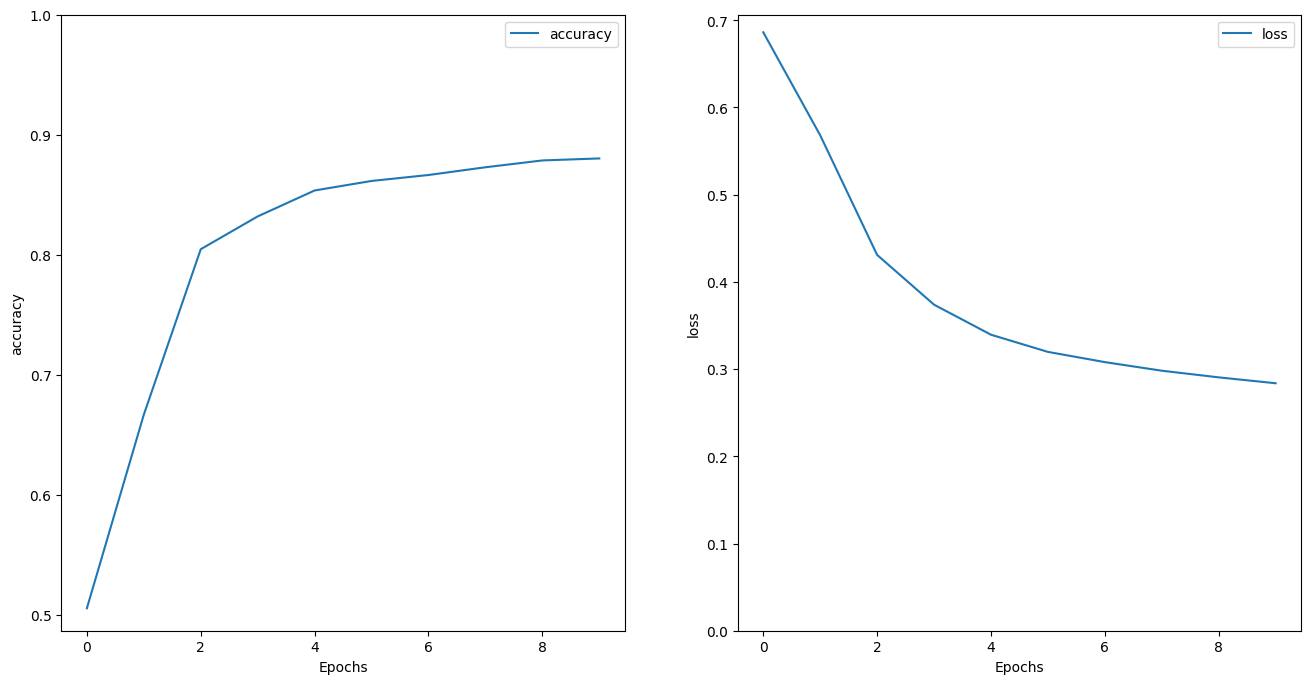

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Ahora necesitamos usar el modelo. Sin embargo, no podemos utilizarlo directamente sino que debemos convertirlo en un tensor de Tensorflow.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])

Ahora lo podemos utilizar directamente. En este caso, si el resultado >= 0 entonces es positivo, en otro caso el texto es negativo.

In [ ]:
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.45729405]]


Probemos con un texto claramente negativo.

In [ ]:
sample_text = ('The movie was terrible!!.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[-1.3553845]]


## LSTM

Definimos el siguiente modelo con la LSTM. Utilizaremos la misma estructura que en la red recurrente anterior.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.5104 - loss: 0.6885 - val_accuracy: 0.7130 - val_loss: 0.5409
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.7591 - loss: 0.4905 - val_accuracy: 0.8349 - val_loss: 0.3793
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.8445 - loss: 0.3616 - val_accuracy: 0.8474 - val_loss: 0.3492
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8586 - loss: 0.3334 - val_accuracy: 0.8443 - val_loss: 0.3413
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.8590 - loss: 0.3297 - val_accuracy: 0.8510 - val_loss: 0.3385
Epoch 6/10
375/391 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8657 - loss: 0.3173

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

In [ ]:
sample_text = ('The movie was terrible!!.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

## BiLSTM

Finalmente definiremos el modelo de LSTM siguiendo el siguiente diagrama.




![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

De este modo podemos implementar a la red recurrente bidireccional.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
model.predict(test_dataset)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

In [ ]:
sample_text = ('The movie was terrible!!.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

## BiLSTM en stack

Es posible apilar redes recurrentes de este modo.

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.5213 - loss: 0.6751
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.8239 - loss: 0.3961
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8484 - loss: 0.3411
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8611 - loss: 0.3271
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 119ms/step - accuracy: 0.8630 - loss: 0.3169
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 76s 103ms/step - accuracy: 0.8612 - loss: 0.3190
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8706 - loss: 0.3044
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.8699 - loss: 0.3000
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8730 - loss: 0.2972
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8680 - loss: 0.3058


In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, None, 64)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,469 (2.01 MB)

 Trainable params: 175,489 (685.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 350,980 (1.34 MB)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8639 - loss: 0.3238
Test Loss: 0.32185423374176025
Test Accuracy: 0.8636000156402588


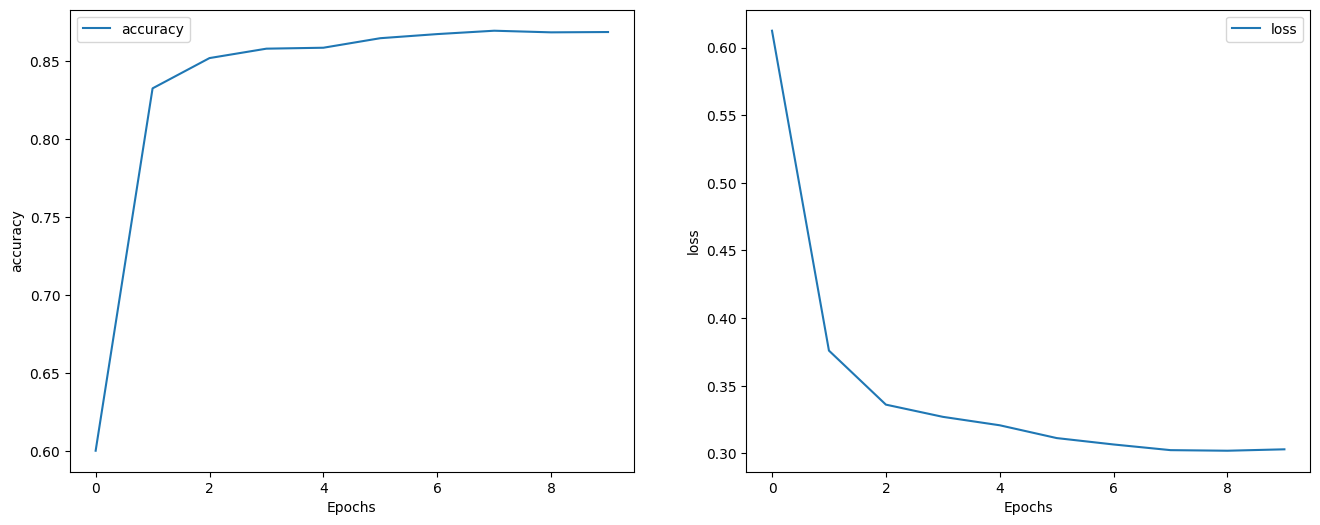

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
[[0.4619339]]


In [ ]:
sample_text = ('The movie was terrible!!.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[-0.7402167]]


## GRU

La GRU (*Gated Recurrent Unit*) es un tipo de red recurrente similar a la LSTM pero con menos compuertas y parámetros.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.4993 - loss: 0.6925
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6266 - loss: 0.5816
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8390 - loss: 0.3640
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8527 - loss: 0.3394
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8698 - loss: 0.3117
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8653 - loss: 0.3154
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8627 - loss: 0.3157
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8634 - loss: 0.3152
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8708 - loss: 0.3079
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.8713 - loss: 0.3009


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8635 - loss: 0.3291
Test Loss: 0.3284541666507721
Test Accuracy: 0.8622400164604187


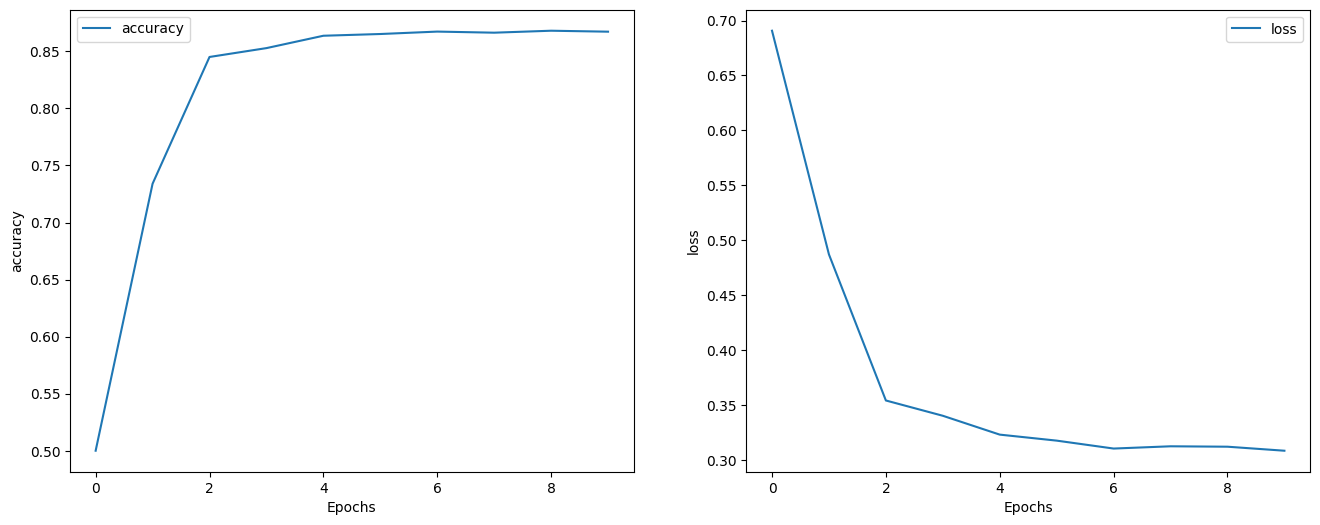

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[[0.7027178]]


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
sample_text_tensor = tf.constant([sample_text])
predictions = model.predict(sample_text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[-1.3503491]]
